In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import matplotlib as mpl
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
import mordred, mordred.descriptors
from mordred import HydrogenBond, Polarizability
from mordred import SLogP, AcidBase, BertzCT, Aromatic, BondCount
from mordred import Calculator

import exmol as exmol
from rdkit.Chem.Draw import rdDepictor
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, plot_roc_curve
os.environ["CUDA_VISIBLE_DEVICES"]="0"
rdDepictor.SetPreferCoordGen(True)

IPythonConsole.ipython_useSVG = True
# sns.set_context('notebook')
# sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
#                         'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = [ '#F06060', '#1BBC9B','#F3B562', '#6e5687', '#5C4B51']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
np.random.seed(0)
soldata = pd.read_csv('https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv')
features_start_at = list(soldata.columns).index('MolWt')

In [2]:
# make object that can compute descriptors
calc = Calculator()
calc.register([HydrogenBond.HBondDonor, HydrogenBond.HBondAcceptor])
calc.register([AcidBase.AcidicGroupCount, AcidBase.BasicGroupCount,
            Aromatic.AromaticBondsCount])
calc.register([SLogP.SLogP, Polarizability.APol,  BertzCT.BertzCT])
calc.register([BondCount.BondCount(type='double'),
            BondCount.BondCount(type='aromatic')])

# make subsample from pandas df
molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in soldata.SMILES]

raw_features = []
for e, c in zip(molecules, calc.map(molecules, quiet=True)):
    raw_features.append([v for v in c.values()])
feature_names = np.array([d.description() for d in calc.descriptors])


In [3]:
raw_features = np.array(raw_features)

In [4]:
# feature_names = soldata.columns[features_start_at:]
# raw_features = soldata[feature_names]
labels = soldata['Solubility']

In [5]:
def pick_features(raw_features):
    fm = raw_features.mean()
    fs = raw_features.std()
    def feature_convert(f):
        f -= fm
        f /= fs
        return f

    features = feature_convert(raw_features)

    # we have some nans in features, likely because std was 0
    features = features.astype(float)
    features_select = np.random.randint(0, len(raw_features[0]), size=3) # np.all(np.isfinite(features), axis=0)
    features = features[:, features_select]
    names = feature_names[features_select]
    return features, names

In [6]:
features, names = pick_features(raw_features)
print(features.shape, names)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.1, shuffle=True)

clf = RandomForestRegressor(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

(9982, 3) ['Wildman-Crippen LogP' 'number of hydrogen bond donor'
 'basic group count']


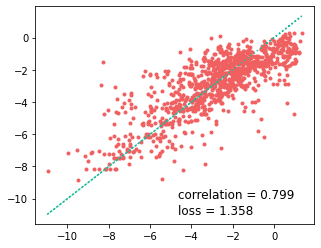

In [7]:
plt.figure(figsize=(5,4))
plt.plot(y_test, predicted, '.')
plt.plot(y_test, y_test, linestyle=':')
plt.text(max(y_test) - 6, min(y_test) + 1, f'correlation = {np.corrcoef(y_test, predicted)[0,1]:.3f}', fontsize=12)
plt.text(max(y_test) - 6, min(y_test), f'loss = {np.sqrt(np.mean((y_test - predicted)**2)):.3f}', fontsize=12)
plt.savefig('RF-ROC.png')

In [8]:
def model_eval(smiles, _=None):
    molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in smiles]
    labels = clf.predict(np.nan_to_num(features))
    return labels
labels = model_eval(soldata.SMILES, features)

In [32]:
smi = soldata.SMILES[1500]
stoned_kwargs={'num_samples': 2000, 'alphabet':exmol.get_basic_alphabet(), 'max_mutations': 2}
space = exmol.sample_space(smi, model_eval, stoned_kwargs=stoned_kwargs)

  0%|          | 0/2500 [00:41<?, ?it/s]
🤘Done🤘: 100%|██████████| 1702.0/1702 [00:05<00:00, 288.22it/s]                     


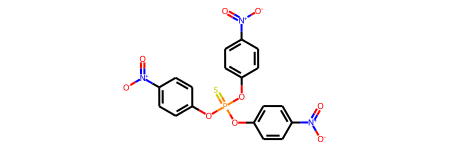

In [33]:
mol = rdkit.Chem.MolFromSmiles( soldata.SMILES[1500])
mol

## Compare Feature significance to linear regression

In [26]:
def calc_feature_importance(descriptors, tstats):
    from collections import OrderedDict
    feature_importance = {a:b for a, b in zip(descriptors, tstats) if not np.isnan(b)}
    feature_importance = dict(sorted(feature_importance.items(),
                 key=lambda item: abs(item[1]),
                 reverse=True))
    #Fitted space important features
    return feature_importance


In [34]:
descriptor_type = 'Classic'
wls_tstats, wls_beta = exmol.lime_explain(space, descriptor_type=descriptor_type)
wls_attr = calc_feature_importance(list(space[0].descriptors.descriptor_names), wls_tstats)
wls_attr

{'acidic group count': -1.6728488396707883,
 'number of hydrogen bond donor': -1.1844534761370131,
 'Wildman-Crippen LogP': -0.76223563006551,
 'number of double bonds in non-kekulized structure': 0.6648244163439453,
 'basic group count': 0.5727939944448265,
 'number of aromatic bonds in non-kekulized structure': 0.23722829243868987,
 'aromatic bonds count': 0.23722829243868576,
 'atomic polarizability': -0.1492036592369568,
 'Bertz CT': 0.13367215364242407,
 'number of hydrogen bond acceptor': -0.12292407782441797}

Text(0.5, 1.0, 'Random Forest Regression')

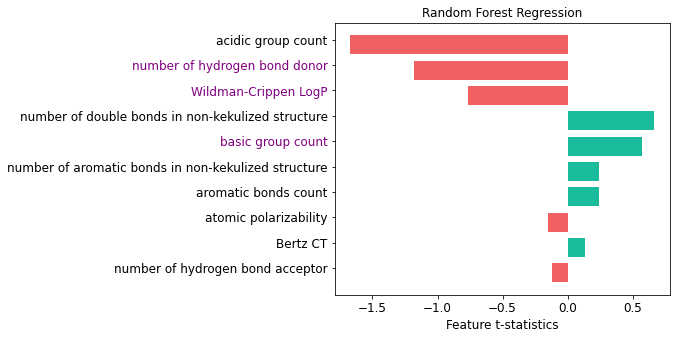

In [35]:
x = (wls_attr.keys())
xaxis = np.arange(len(x))
x_colors = ['purple' if t in names else 'black' for t in x]

rf_imp = {a:b for a, b in zip(names, clf.feature_importances_)}
rf_x = np.zeros(len(x))
rf_y = np.zeros(len(x))
for i, j in enumerate(x):
    if j in rf_imp:
        rf_x[i] = i
        rf_y[i] = rf_imp[j]
      
width = [wls_attr[i] for i in x]
colors = ['#F06060' if i<0 else '#1BBC9B' for i in width]

fig, ax = plt.subplots(figsize=(6,5))
ax.barh(xaxis+0.2, width, 0.75, label='WLS', color = colors)

plt.xticks(fontsize=12)
plt.xlabel('Feature t-statistics', fontsize=12)
plt.yticks(xaxis, x, fontsize=12)
[t.set_color(i) for (i,t) in
 zip(x_colors, ax.yaxis.get_ticklabels())]
plt.gca().invert_yaxis()
plt.title('Random Forest Regression', fontsize=12)
# plt.savefig('baseline.svg', bbox_inches='tight', dpi=180)